## The Twin Spirals Problem

This notebook contains code to train two different neural networks to attempt to classify points in two groups according to the following formulae:

Group A
$$
x = (r * math.cos(φ))/13 + 0.5 \\
y = (r * math.sin(φ))/13 + 0.5
$$
Group B
$$
x = -(r * math.cos(φ))/13 + 0.5 \\
y = -(r * math.sin(φ))/13 + 0.5
$$

First we will create the data, and display it in both still and animated formats.

In [315]:
# Set up the initial packages for data creation and display

import pandas as pd
from math import pi, sin, cos
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio

In [316]:
# Define the data functions
# Spiral calculation source: https://conx.readthedocs.io/en/latest/Two-Spirals.html

def spiral_xy(i, spiral_num):
    φ = i/16 * pi
    r = 6.5 * ((104 - i)/104)
    x = (r * cos(φ) * spiral_num)
    y = (r * sin(φ) * spiral_num)
    label = 0 if spiral_num < 0 else 1
    return [x, y, label]

In [317]:
# Create the data

NUM_POINTS = 100 # Set a global variable for the number of data points we'll have
a = pd.DataFrame([spiral_xy(i, 1) for i in range(NUM_POINTS)])
b = pd.DataFrame([spiral_xy(i, -1) for i in range(NUM_POINTS)])


In [318]:
# Create an image and animated gif of the data

filenames = []
for i in range(0,100):
    filename = f'spiral_images/plot_{i}.png'

    plt.figure(figsize=(8,8), dpi=200)
    plt.scatter(a.iloc[:i,0], a.iloc[:i,1], label='A')
    plt.scatter(b.iloc[:i,0], b.iloc[:i,1], label='B')
    plt.xlim(-7,7); plt.ylim(-7,7)
    plt.xlabel('x'); plt.ylabel('y')
    plt.legend()
    plt.savefig(filename)
    plt.clf()
    plt.close()

    filenames.append(imageio.imread(filename))

imageio.mimsave(f'spiral_images/spiral.gif', filenames, duration=0.1)

# Clean up the unneeded .png files
dir_name = "./spiral_images/"
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".png"):
        os.remove(os.path.join(dir_name, item))

/var/folders/7v/p9vbgcs90dz7kjt57fw7yq3r0000gn/T/ipykernel_23736/1760160.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  filenames.append(imageio.imread(filename))


In [337]:
import glob, os
for file in glob.glob("./XYNet_images/*.gif"): os.remove(file)

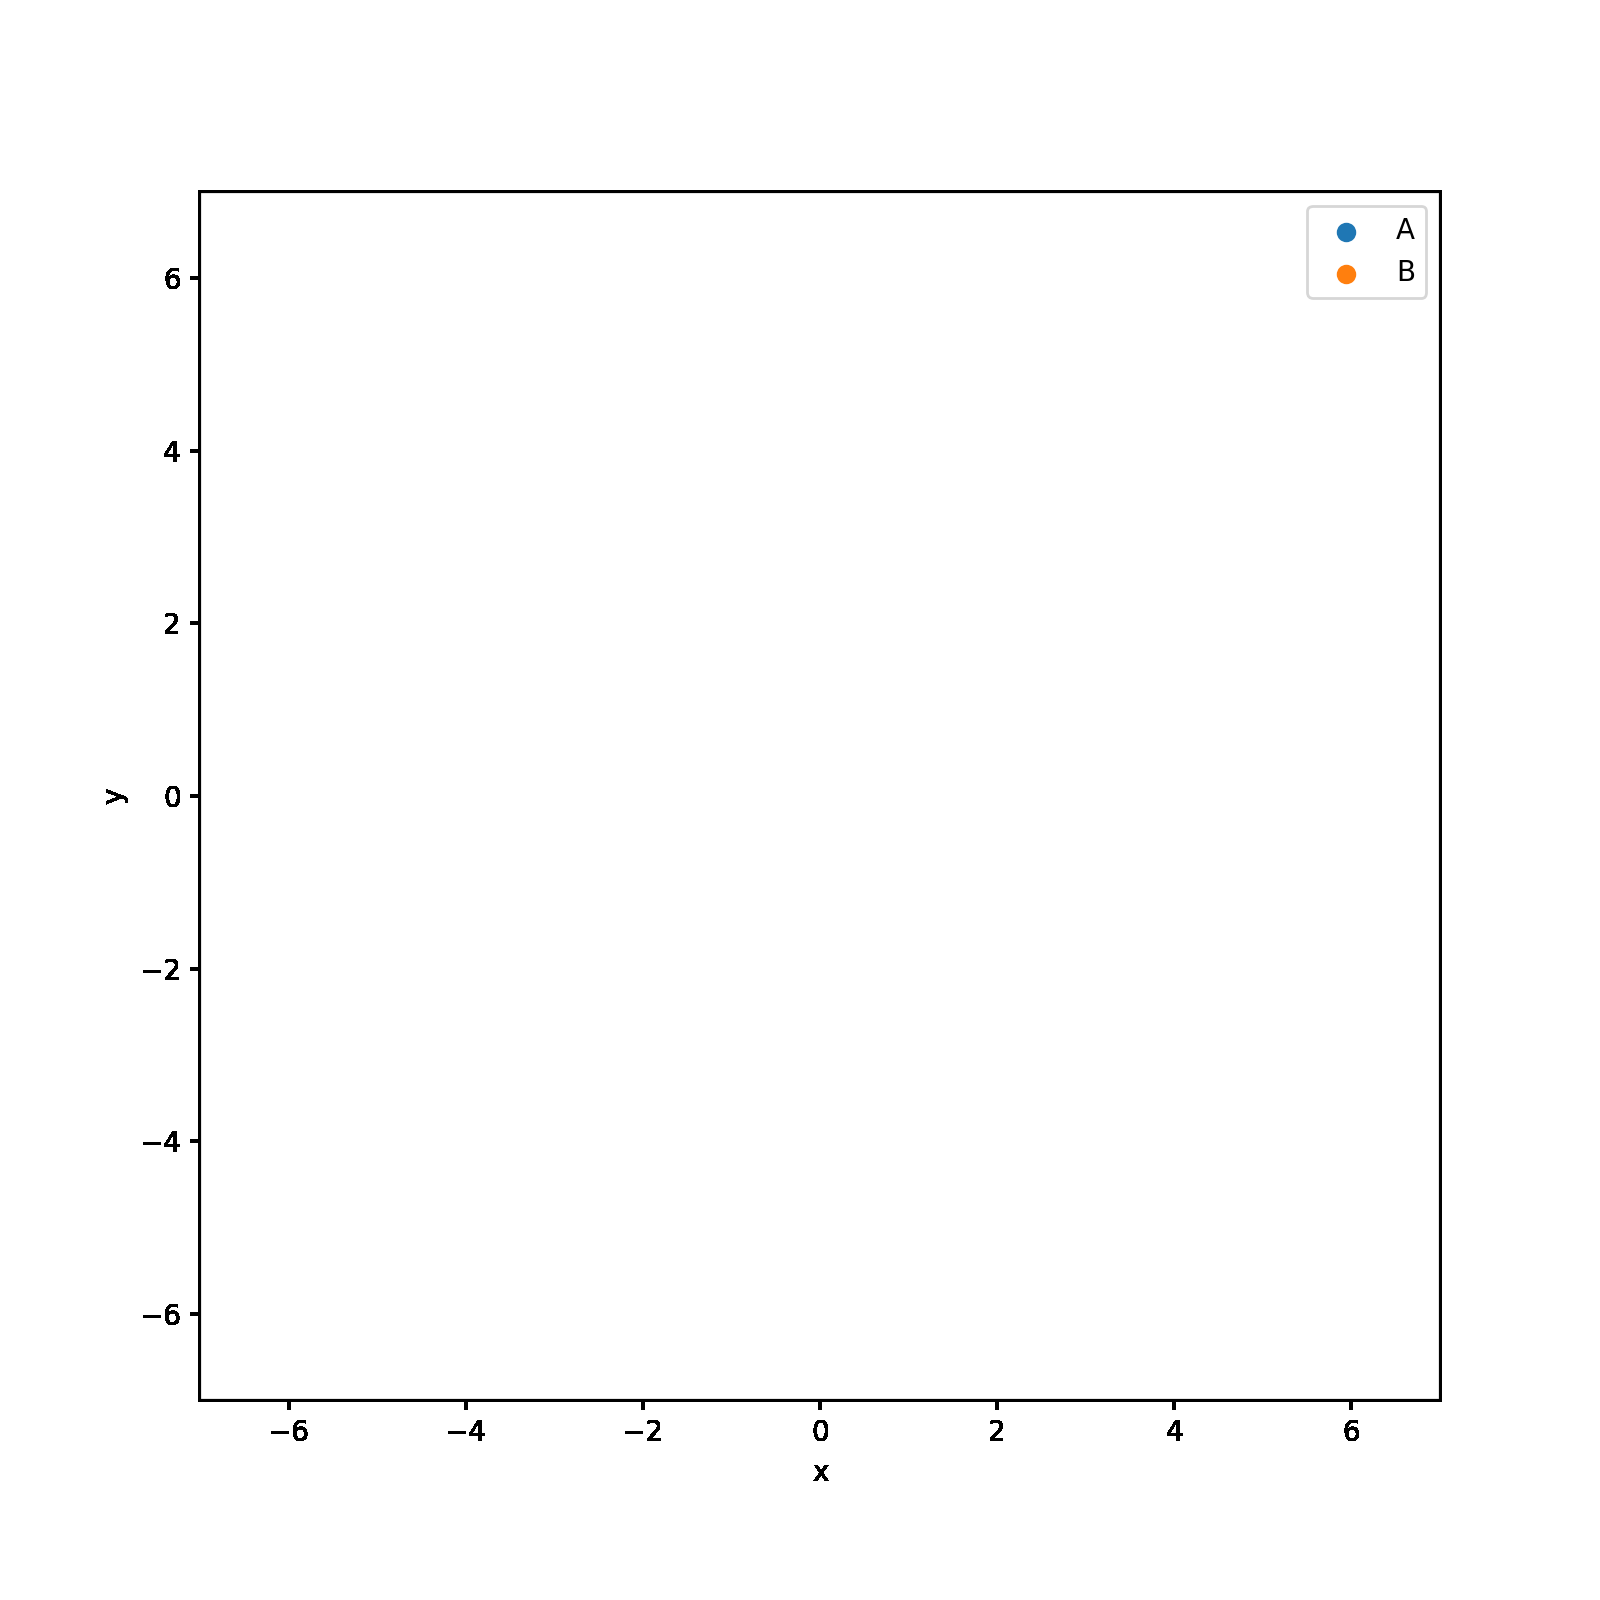

In [319]:
# View the animated graphic

from IPython.display import Image
Image('./spiral_images/spiral.gif', width=500, height=500)

We can see now that the data forms two distinct spirals.
Next, we train a simple neural network to try and determine which spiral each point belongs to using x and y co-ordinates.

In [320]:
# Set up the packages for neural network learning

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [321]:
# Next we define our hyper-parameters which we can tune to optimise performance
INIT = 0.1 # Initial weight size
HID = 30 # Number of hidden nodes
LR = 0.10 # The learning rate
EPOCHS = 20000 # Maximum number of training epochs

In [322]:
# Define our first attempt at a neural network

class XYNet(torch.nn.Module):
    def __init__(self, num_hid):
        super(XYNet, self).__init__()
        self.input = nn.Linear(2, num_hid) # Input layer
        self.hidden1 = nn.Linear(num_hid, num_hid) # First hidden layer
        self.hidden2 = nn.Linear(num_hid, 1) # Third hidden layer (for experimentation)
        self.tanh = nn.Tanh() # Default model is tanh
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.input(input)
        output = self.tanh(output); self.layer1 = output
        output = self.hidden1(output)
        output = self.tanh(output); self.layer2 = output
        output = self.hidden2(output)        
        output = self.sigmoid(output)
        return output

In [323]:
# Define a graphing function for showing the hidden layer outputs

def graph_hidden(net, layer=None, node=None):
    # Boilerplate graph configuration from spiral_main
    xrange = torch.arange(start=-7,end=7.1,step=0.01,dtype=torch.float32)
    yrange = torch.arange(start=-6.6,end=6.7,step=0.01,dtype=torch.float32)
    xcoord = xrange.repeat(yrange.size()[0])
    ycoord = torch.repeat_interleave(yrange, xrange.size()[0], dim=0)
    grid = torch.cat((xcoord.unsqueeze(1),ycoord.unsqueeze(1)),1)

    with torch.no_grad(): # suppress updating of gradients
        net.eval()        # toggle batch norm, dropout
        output = net(grid)

        if layer == 1:
            pred = (net.layer1[:, node] >= 0).float()
        elif layer == 2:
            pred = (net.layer2[:, node] >= 0).float()
        else:
            pass

        # plot function computed by model
        plt.clf()
        plt.pcolormesh(xrange,yrange,pred.cpu().view(yrange.size()[0],xrange.size()[0]), cmap='Wistia')

In [324]:
# Define a graphing function for showing the output

def graph_output(net):
    xrange = torch.arange(start=-7,end=7.1,step=0.01,dtype=torch.float32) # Default start -7, end 7.1, step 0.01
    yrange = torch.arange(start=-6.6,end=6.7,step=0.01,dtype=torch.float32)  # Default start -6.6, end 6.7, step 0.01
    xcoord = xrange.repeat(yrange.size()[0])
    ycoord = torch.repeat_interleave(yrange, xrange.size()[0], dim=0)
    grid = torch.cat((xcoord.unsqueeze(1),ycoord.unsqueeze(1)),1)

    with torch.no_grad(): # suppress updating of gradients
        net.eval()        # toggle batch norm, dropout
        output = net(grid)
        net.train() # toggle batch norm, dropout back again

        pred = (output >= 0.5).float()

        # plot function computed by model
        plt.clf()
        plt.pcolormesh(xrange,yrange,pred.cpu().view(yrange.size()[0],xrange.size()[0]), cmap='Wistia')

In [325]:
# Define the training function

def train(net, train_loader, optimizer):
    total=0
    correct=0
    for batch_id, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()    # zero the gradients
        output = net(data)       # apply network
        loss = F.binary_cross_entropy(output,target)
        loss.backward()          # compute gradients
        optimizer.step()         # update weights
        pred = (output >= 0.5).float()
        correct += (pred == target).float().sum()
        total += target.size()[0]
        accuracy = 100*correct/total

    if epoch % 100 == 0:
        print('ep:%5d loss: %6.4f acc: %5.2f' %
             (epoch,loss.item(),accuracy))

    return accuracy

In [326]:
# Set up the data

df = pd.concat([a, b], ignore_index=True) # Join the dataset for spirals A and B
data = torch.tensor(df.values,dtype=torch.float32) # Create a tensor of the data

num_input = data.shape[1] - 1 # Defines the number of inputs (2)

full_input  = data[:,0:num_input] # Creates a tensor of just the inputs (X and Y coords)
full_target = data[:,num_input:num_input+1] # Creates a tensor of just the labels (spiral 0 or 1 for A and B respectively)

train_dataset = torch.utils.data.TensorDataset(full_input, full_target) # Creates a 'TensorDataset' of the features and labels
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=NUM_POINTS) # Creates a 'DataLoader' with our full 100 data points

In [327]:
# Define our network
net = XYNet(HID) # The number sets our number of hidden nodes in the middle of the network

In [328]:
# Initialise weights for the model, set up the optimiser, and run the training loop

if list(net.parameters()):
    # initialize weight values
    for m in list(net.parameters()):
        m.data.normal_(0, INIT)

    # use Adam optimizer
    optimizer = torch.optim.Adam(net.parameters(),eps=0.000001,lr=LR,
                                 betas=(0.9,0.999),weight_decay=0.0001)

    #optimizer =  torch.optim.SGD(net.parameters(), lr=LR, momentum=0.1)

    # training loop
    for epoch in range(1, EPOCHS):
        accuracy = train(net, train_loader, optimizer)
        if epoch % 100 == 0 and accuracy == 100:
            break

ep:  100 loss: 0.6750 acc: 62.50
ep:  200 loss: 0.5410 acc: 63.50
ep:  300 loss: 0.5173 acc: 68.50
ep:  400 loss: 0.5616 acc: 64.00
ep:  500 loss: 0.5133 acc: 72.50
ep:  600 loss: 0.4738 acc: 72.50
ep:  700 loss: 0.4449 acc: 73.00
ep:  800 loss: 0.4337 acc: 73.00
ep:  900 loss: 0.3825 acc: 76.00
ep: 1000 loss: 0.4550 acc: 73.00
ep: 1100 loss: 0.3733 acc: 65.50
ep: 1200 loss: 0.4700 acc: 72.50
ep: 1300 loss: 0.4008 acc: 76.50
ep: 1400 loss: 0.3608 acc: 79.00
ep: 1500 loss: 0.4382 acc: 73.50
ep: 1600 loss: 0.3452 acc: 77.00
ep: 1700 loss: 0.3598 acc: 66.00
ep: 1800 loss: 0.3258 acc: 80.00
ep: 1900 loss: 0.3692 acc: 80.50
ep: 2000 loss: 0.4181 acc: 72.50
ep: 2100 loss: 0.3659 acc: 82.00
ep: 2200 loss: 0.3450 acc: 74.50
ep: 2300 loss: 0.3784 acc: 76.00
ep: 2400 loss: 0.3181 acc: 74.50
ep: 2500 loss: 0.3891 acc: 76.00
ep: 2600 loss: 0.3193 acc: 81.50
ep: 2700 loss: 0.2652 acc: 85.00
ep: 2800 loss: 0.3995 acc: 75.50
ep: 2900 loss: 0.3138 acc: 81.50
ep: 3000 loss: 0.2618 acc: 86.00
ep: 3100 l

/var/folders/7v/p9vbgcs90dz7kjt57fw7yq3r0000gn/T/ipykernel_23736/2112472067.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


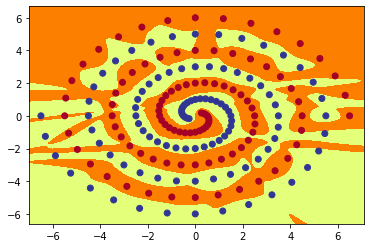

In [329]:
# Graph our hidden and output units

# Graph hidden units
for layer in [1,2]:
    filenames = []
    for node in range(HID):
        graph_hidden(net, layer, node)
        plt.scatter(full_input[:,0],full_input[:,1],
                    c=1-full_target[:,0],cmap='RdYlBu')
        filename = 'XYNet_images/%s_%d_%d.png' % ('XYNet', layer, node)
        plt.savefig(filename)
        filenames.append(filename)
        
    # Create an animation for the images in each layer
    with imageio.get_writer(f'XYNet_images/XYNet_{layer}.gif', mode='I') as writer:
        
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove unneeded .png files
    for filename in set(filenames):
        os.remove(filename)

# Graph output unit
graph_output(net)
plt.scatter(full_input[:,0],full_input[:,1],
            c=1-full_target[:,0],cmap='RdYlBu')
plt.savefig('XYNet_images/XYNet_out.png')


/var/folders/7v/p9vbgcs90dz7kjt57fw7yq3r0000gn/T/ipykernel_23736/419225710.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  filenames.append(imageio.imread(filename))


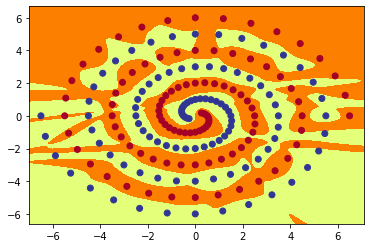

In [330]:
# SECOND VERSION: Graph our hidden and output units

# Graph hidden units
for layer in [1,2]:
    filenames = []
    for node in range(HID):
        graph_hidden(net, layer, node)
        plt.scatter(full_input[:,0],full_input[:,1],
                    c=1-full_target[:,0],cmap='RdYlBu')
        filename = 'XYNet_images/%s_%d_%d.png' % ('XYNet', layer, node)
        plt.savefig(filename)
        filenames.append(imageio.imread(filename))
        
    # Create an animation for the images in each layer
    imageio.mimsave(f'XYNet_images/XYNet_{layer}.gif', filenames, duration=1)

# Graph output unit
graph_output(net)
plt.scatter(full_input[:,0],full_input[:,1],
            c=1-full_target[:,0],cmap='RdYlBu')
plt.savefig('XYNet_images/XYNet_out.png')

# Remove unneeded .png files
dir_name = "./XYNet_images/"
test = os.listdir(dir_name)
for item in test:
    if item.endswith(".png"):
        os.remove(os.path.join(dir_name, item))

Sometimes our model XYNet achieves 100% classification accuracy after 20,000 training epochs, and sometimes not.
We can see in the animations below the way that each node in each layer 'specialises' in separating the input space for the purpose of classification. The complex shapes of the second layer highlight that they are *combinations* of nodes in the previous layer, allowing for further abstraction in carving up the input space.

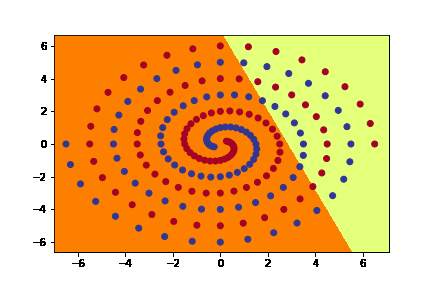

In [332]:
# View the animated graphics for hidden layer 1
Image('./XYNet_images/XYNet_1.gif', width=500, height=350)

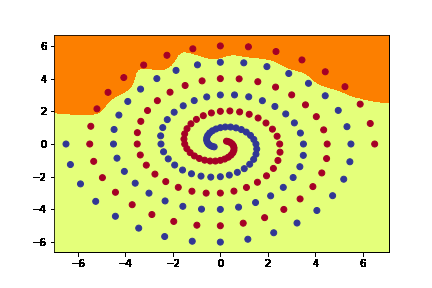

In [333]:
# View the animated graphics for hidden layer 2
Image('./XYNet_images/XYNet_2.gif', width=500, height=350)